In [90]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('project3.ok')

Assignment: Project 3: Movie Classification
OK, version v1.18.1



# Project 3: Movie Classification
Welcome to the third project of Data 8!  You will build a classifier that guesses whether a movie is a comedy or a thriller, using only the number of times words appear in the movies's screenplay.  By the end of the project, you should know how to:

1. Build a k-nearest-neighbors classifier.
2. Test a classifier on data.

### Logistics


**Deadline.** This project is due at 11:59pm on Friday 12/04. You can earn an early submission bonus point by submitting your completed project by 11:59 on Thursday 12/03. It's **much** better to be early than late, so start working now.

**Checkpoint.** For full credit, you must also **complete Part 2 of the project (out of 4) and submit it by 11:59pm on Friday 11/20**. 

**Partners.** You may work with one other partner; this partner **must** be enrolled in the same lab section as you are. Only one of you is required to submit the project. On [okpy.org](http://okpy.org), the person who submits should also designate their partner so that both of you receive credit.

**Rules.** Don't share your code with anybody but your partner. You are welcome to discuss questions with other students, but don't share the answers. The experience of solving the problems in this project will prepare you for exams (and life). If someone asks you for the answer, resist! Instead, you can demonstrate how you would solve a similar problem.

**Support.** You are not alone! Come to office hours, post on Piazza, and talk to your classmates. If you want to ask about the details of your solution to a problem, make a private Piazza post and the staff will respond. If you're ever feeling overwhelmed or don't know how to make progress, email your TA or tutor for help. You can find contact information for the staff on the [course website](http://data8.org/fa20/staff.html).

**Tests.** Passing the tests for a question **does not** mean that you answered the question correctly. Tests usually only check that your table has the correct column labels. However, more tests will be applied to verify the correctness of your submission in order to assign your final score, so be careful and check your work!

**Advice.** Develop your answers incrementally. To perform a complicated table manipulation, break it up into steps, perform each step on a different line, give a new name to each result, and check that each intermediate result is what you expect. You can add any additional names or functions you want to the provided cells. Also, please be sure to not re-assign variables throughout the notebook! For example, if you use max_temperature in your answer to one question, do not reassign it later on.

To get started, load `datascience`, `numpy`, `plots`, and `ok`.

In [91]:
# Don't change this cell; just run it. 
# When you log-in please hit return (not shift + return) after typing in your email
from client.api.notebook import *
def new_save_notebook(self):
    """ Saves the current notebook by
        injecting JavaScript to save to .ipynb file.
    """
    try:
        from IPython.display import display, Javascript
    except ImportError:
        log.warning("Could not import IPython Display Function")
        print("Make sure to save your notebook before sending it to OK!")
        return

    if self.mode == "jupyter":
        display(Javascript('IPython.notebook.save_checkpoint();'))
        display(Javascript('IPython.notebook.save_notebook();'))
    elif self.mode == "jupyterlab":
        display(Javascript('document.querySelector(\'[data-command="docmanager:save"]\').click();'))   

    print('Saving notebook...', end=' ')

    ipynbs = [path for path in self.assignment.src
              if os.path.splitext(path)[1] == '.ipynb']
    # Wait for first .ipynb to save
    if ipynbs:
        if wait_for_save(ipynbs[0]):
            print("Saved '{}'.".format(ipynbs[0]))
        else:
            log.warning("Timed out waiting for IPython save")
            print("Could not automatically save \'{}\'".format(ipynbs[0]))
            print("Make sure your notebook"
                  " is correctly named and saved before submitting to OK!".format(ipynbs[0]))
            return False                
    else:
        print("No valid file sources found")
    return True

def wait_for_save(filename, timeout=600):
    """Waits for FILENAME to update, waiting up to TIMEOUT seconds.
    Returns True if a save was detected, and False otherwise.
    """
    modification_time = os.path.getmtime(filename)
    start_time = time.time()
    while time.time() < start_time + timeout:
        if (os.path.getmtime(filename) > modification_time and
            os.path.getsize(filename) > 0):
            return True
        time.sleep(0.2)
    return False

Notebook.save_notebook = new_save_notebook
from datascience import *
import numpy as np
import math

# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# These lines load the tests.
from client.api.notebook import Notebook
ok = Notebook('project3.ok')
_ = ok.auth(inline=True)

Assignment: Project 3: Movie Classification
OK, version v1.18.1

Successfully logged in as esong200@berkeley.edu


# 1. The Dataset

In this project, we are exploring movie screenplays. We'll be trying to predict each movie's genre from the text of its screenplay. In particular, we have compiled a list of 5,000 words that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

Run the cell below to read the `movies` table. **It may take up to a minute to load.**

In [92]:
movies = Table.read_table('movies.csv')
movies.where("Title", "runaway bride").select(0, 1, 2, 3, 4, 14, 49, 1042, 4004)

Title,Year,Rating,Genre,# Words,breez,england,it,bravo
runaway bride,1999,5.2,comedy,4895,0,0,0.0234092,0


The above cell prints a few columns of the row for the comedy movie *Runaway Bride*.  The movie contains 4895 words. The word "it" appears 115 times, as it makes up  $\frac{115}{4895} \approx 0.0234092$ of the words in the movie. The word "england" doesn't appear at all.
This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format. In this project, we will investigate whether this representation is sufficient to build an accurate genre classifier.

All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

*Note: All movies in our dataset have their titles lower-cased.* 

In [93]:
title_index = movies.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

row_for_title('toy story')

Row(Title='toy story', Year='1995', Rating=8.2, Genre='comedy', # Words=3016, she=0.0017427675148135302, decid=0.000348553502962706, talk=0.0017427675148135302, wit=0.0, razor=0.0, slam=0.0, credit=0.0, rai=0.0, hugh=0.0, breez=0.0, conscienc=0.0, audienc=0.0, cathi=0.0, log=0.0, met=0.0, chosen=0.0, grip=0.0, booz=0.0, bianca=0.0, doubl=0.000348553502962706, agent=0.0, exit=0.0, carpent=0.0, underground=0.0, clemenza=0.0, gain=0.0, neg=0.000697107005925412, majesti=0.0, studio=0.0, chri=0.0, spin=0.0, greater=0.0, eaten=0.0, vibrat=0.0, stupid=0.001045660508888118, cigarett=0.0, jesu=0.0, mani=0.0, violin=0.0, financi=0.000348553502962706, bai=0.0, cop=0.0, neighbor=0.0, cd=0.0, england=0.0, made=0.000348553502962706, conni=0.0, instinct=0.0, took=0.0, jacquelin=0.0, mace=0.0, disappear=0.0, waltz=0.0, behind=0.000348553502962706, bourbon=0.0, favorit=0.000697107005925412, benni=0.0, manhattan=0.0, nixon=0.0, lunch=0.0, principl=0.0, tradit=0.0, counterfeit=0.0, sophi=0.0, third=0.0, 

For example, the fastest way to find the frequency of "fun" in the movie *Toy Story* is to access the `'fun'` item from its row. Check the original table to see if this worked for you!

In [94]:
row_for_title('toy story').item('fun') 

0.000348553502962706

#### Question 1.0
Set `expected_row_sum` to the number that you __expect__ will result from summing all proportions in each row, excluding the first five columns. Think about what any one row adds up to.

<!--
BEGIN QUESTION
name: q1_0
-->

In [95]:
# Set row_sum to a number that's the (approximate) sum of each row of word proportions.
expected_row_sum = 1

In [96]:
ok.grade("q1_0");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



This dataset was extracted from [a dataset from Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). After transforming the dataset (e.g., converting the words to lowercase, removing the naughty words, and converting the counts to frequencies), we created this new dataset containing the frequency of 5000 common words in each movie.

In [97]:
print('Words with frequencies:', movies.drop(np.arange(5)).num_columns) 
print('Movies with genres:', movies.num_rows)

Words with frequencies: 5000
Movies with genres: 370


## 1.1. Word Stemming
The columns other than "Title", "Year", "Rating", "Genre", and "# Words" in the `movies` table are all words that appear in some of the movies in our dataset.  These words have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie. This is a common technique used in machine learning and natural language processing.

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table that will let you see examples of unstemmed versions of each stemmed word.  Run the code below to load it.

In [98]:
# Just run this cell.
vocab_mapping = Table.read_table('stem.csv')
stemmed = np.take(movies.labels, np.arange(3, len(movies.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1110))

Stem,Word
bond,bonding
bone,bone
bone,boning
bone,bones
bonu,bonus
book,bookings
book,books
book,booking
book,booked
book,book


#### Question 1.1.1
Assign `stemmed_message` to the stemmed version of the word "elements".

<!--
BEGIN QUESTION
name: q1_1_1
-->

In [99]:
#print(vocab_table)
stemmed_message = vocab_table.where("Word", are.containing("elements")).column("Stem").item(0)
stemmed_message

'element'

In [100]:
ok.grade("q1_1_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.1.2
What stem in the dataset has the most words that are shortened to it? Assign `most_stem` to that stem.

<!--
BEGIN QUESTION
name: q1_1_2
-->

In [101]:
most_stem = vocab_table.group("Stem").sort("count", descending = True).item(0).column("Stem").item(0)
most_stem

'gener'

In [102]:
ok.grade("q1_1_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.1.3
What is the longest word in the dataset whose stem wasn't shortened? Assign that to `longest_uncut`. Break ties alphabetically from Z to A (so if your options are "albatross" or "batman", you should pick "batman").

<!--
BEGIN QUESTION
name: q1_1_3
-->

In [103]:
# In our solution, we found it useful to first add columns with
# the length of the word and the length of the stem,
# and then to add a column with the difference between those lengths.
# What will the difference be if the word is not shortened?

tbl_with_lens = vocab_table.with_columns("Word Length", vocab_table.apply(len, "Word"), 
                                         "Stem Length", vocab_table.apply(len, "Stem"))
differences = tbl_with_lens.column("Word Length")-tbl_with_lens.column("Stem Length")

tbl_with_dif = tbl_with_lens.with_column("Length Difference", differences)


longest_uncut_words = tbl_with_dif.where("Length Difference", are.equal_to(0)).sort("Word Length", descending = True)
longest_uncut_len = longest_uncut_words.column("Word Length").item(0)
longest_uncut = longest_uncut_words.where("Word Length", are.equal_to(longest_uncut_len)).sort("Word", descending = True).column("Word").item(0)
longest_uncut

'misunderstand'

In [104]:
ok.grade("q1_1_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.1.4
How many stems have only one word that is shortened to them? For example, if the stem "book" only maps to the word "books" and if the stem "a" only maps to the word "a," both should be counted as stems that map only to a single word.

Assign `count_single_stems` to the count of stems that map to one word only. 

<!--
BEGIN QUESTION
name: q1_1_4
-->

In [105]:
vocab_table_grouped = vocab_table.group("Stem")
count_single_stems = vocab_table_grouped.where("count", are.equal_to(1)).num_rows
count_single_stems

1408

In [106]:
ok.grade("q1_1_4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 1.2. Exploratory Data Analysis: Linear Regression

Let's explore our dataset before trying to build a classifier. To start, we'll look at the relationship between words in proportions. 

The first association we'll investigate is the association between the proportion of words that are "outer" and the proportion of words that are "space". 

As usual, we'll investigate our data visually before performing any numerical analysis.

Run the cell below to plot a scatter diagram of space proportions vs outer proportions and to create the `outer_space` table.

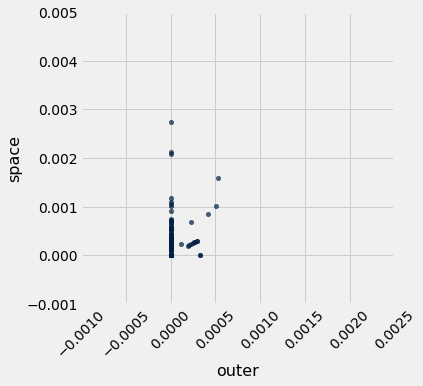

In [107]:
# Just run this cell!
outer_space = movies.select("outer", "space")
outer_space.scatter("outer", "space")
plots.axis([-0.001, 0.0025, -0.001, 0.005]);
plots.xticks(rotation=45);

#### Question 1.2.1
Looking at that chart it is difficult to see if there is an association. Calculate the correlation coefficient for the association between proportion of words that are "outer" and the proportion of words that are "space" for every movie in the dataset, and assign it to `outer_space_r`.

<!--
BEGIN QUESTION
name: q1_2_1
-->

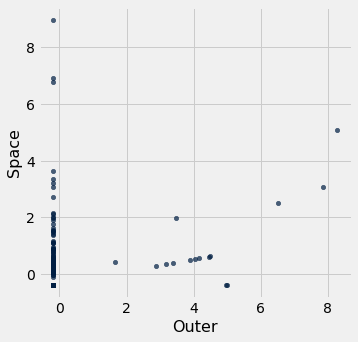

In [108]:
# Our solution took multiple lines
# these two arrays should make your code cleaner!
outer = movies.column("outer") #x
space = movies.column("space") #y

outer_su = (outer-np.mean(outer))/np.std(outer)
space_su = (space-np.mean(space))/np.std(space)

outer_space_r = np.mean(outer_su*space_su)
outer_space_r

Table().with_columns("Outer", outer_su, "Space", space_su).scatter("Outer", "Space")

In [109]:
ok.grade("q1_2_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.2.2
Choose two *different* words in the dataset with a correlation higher than 0.2 or smaller than -0.2 that are not *outer* and *space* and plot a scatter plot with a line of best fit for them. The code to plot the scatter plot and line of best fit is given for you, you just need to calculate the correct values to `r`, `slope` and `intercept`.

*Hint: It's easier to think of words with a positive correlation, i.e. words that are often mentioned together*.

*Hint 2: Try to think of common phrases or idioms*.

<!--
BEGIN QUESTION
name: q1_2_2
manual: true
image: true
-->
<!-- EXPORT TO PDF -->

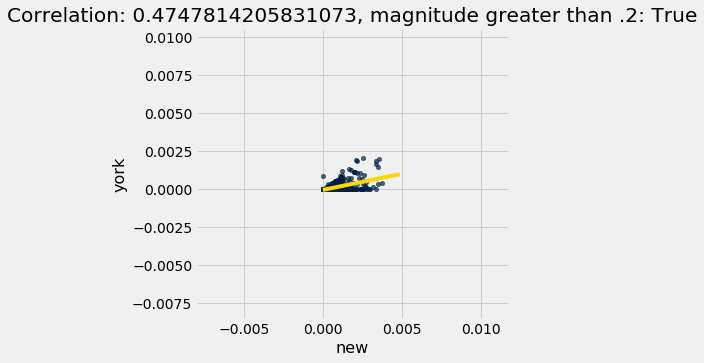

In [110]:
word_x = "new"
word_y = "york"

# These arrays should make your code cleaner!
arr_x = movies.column(word_x)
arr_y = movies.column(word_y)

x_su = (arr_x-np.mean(arr_x))/np.std(arr_x)
y_su = (arr_y-np.mean(arr_y))/np.std(arr_y)

r = np.mean(x_su*y_su)

slope = r*(np.std(arr_y))/np.std(arr_x)
intercept = np.mean(arr_y) - slope*np.mean(arr_x)

# DON'T CHANGE THESE LINES OF CODE
movies.scatter(word_x, word_y)
max_x = max(movies.column(word_x))
plots.title(f"Correlation: {r}, magnitude greater than .2: {abs(r) >= 0.2}")
plots.plot([0, max_x * 1.3], [intercept, intercept + slope * (max_x*1.3)], color='gold');

#### Question 1.2.3
Imagine that you picked the words "san" and "francisco" as the two words that you would expect to be correlated because they compose the city name San Francisco. Assign `unexpected` to either the number 1 or the number 2 according to which statement is true regarding the correlation between "san" and "francisco."

1. "san" can also preceed other city names like San Diego and San Jose. This might lead to "san" appearing in movies without "francisco," and would reduce the correlation between "san" and "francisco."
2. "san" can also preceed other city names like San Diego and San Jose. The fact that "san" could appear more often in front of different cities and without "francisco" would increase the correlation between "san" and "francisco." 

<!--
BEGIN QUESTION
name: q1_2_3
-->

In [111]:
unexpected = 1

In [112]:
ok.grade("q1_2_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 1.3. Splitting the dataset
We're going to use our `movies` dataset for two purposes.

1. First, we want to *train* movie genre classifiers.
2. Second, we want to *test* the performance of our classifiers.

Hence, we need two different datasets: *training* and *test*.

The purpose of a classifier is to classify unseen data that is similar to the training data. Therefore, we must ensure that there are no movies that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the top for training and the rest for test. 

Run the code below (without changing it) to separate the datasets into two tables.

In [113]:
# Here we have defined the proportion of our data
# that we want to designate for training as 17/20ths
# of our total dataset.  3/20ths of the data is
# reserved for testing.

training_proportion = 17/20

num_movies = movies.num_rows
num_train = int(num_movies * training_proportion)
num_test = num_movies - num_train

train_movies = movies.take(np.arange(num_train))
test_movies = movies.take(np.arange(num_train, num_movies))

print("Training: ",   train_movies.num_rows, ";",
      "Test: ",       test_movies.num_rows)

Training:  314 ; Test:  56


#### Question 1.3.1
Draw a horizontal bar chart with two bars that show the proportion of Comedy movies in each dataset. Complete the function `comedy_proportion` first; it should help you create the bar chart.

<!--
BEGIN QUESTION
name: q1_3_1
manual: true
image: true
-->
<!-- EXPORT TO PDF -->

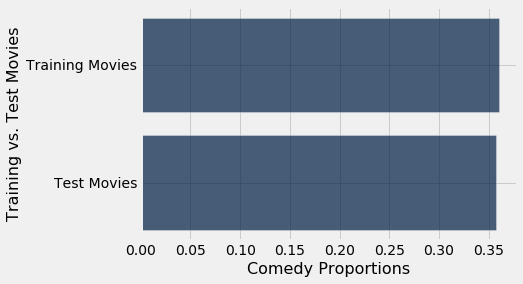

In [114]:
def comedy_proportion(table):
    # Return the proportion of movies in a table that have the Comedy genre.
    return table.where("Genre", are.containing("comedy")).num_rows / table.num_rows

proportions = make_array(comedy_proportion(train_movies), comedy_proportion(test_movies))
labels = make_array("Training Movies", "Test Movies")
Table().with_columns("Training vs. Test Movies", labels, 
                     "Comedy Proportions", proportions).barh("Training vs. Test Movies")
# The staff solution took multiple lines.  Start by creating a table.
# If you get stuck, think about what sort of table you need for barh to work

# 2. K-Nearest Neighbors - A Guided Example

K-Nearest Neighbors (k-NN) is a classification algorithm.  Given some numerical *attributes* (also called *features*) of an unseen example, it decides whether that example belongs to one or the other of two categories based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

An attribute (feature) we have about each movie is *the proportion of times a particular word appears in the movies*, and the labels are two movie genres: comedy and thriller.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_movies` table.

To build understanding, we're going to visualize the algorithm instead of just describing it.

## 2.1. Classifying a movie

In k-NN, we classify a movie by finding the `k` movies in the *training set* that are most similar according to the features we choose. We call those movies with similar features the *nearest neighbors*.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each movie.  The features we will use are the proportions of the words "water" and "feel" in the movie.  Taking the movie *Monty Python and the Holy Grail* (in the test set), 0.000804074 of its words are "water" and 0.0010721 are "feel". This movie appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  We will say that the *distance* between two movies is the straight-line distance between them when we plot their features in a scatter diagram. 

**This distance is called the Euclidean ("yoo-KLID-ee-un") distance, whose formula is $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$.**

For example, in the movie *Clerks.* (in the training set), 0.00016293 of all the words in the movie are "water" and 0.00154786 are "feel".  Its distance from *Monty Python and the Holy Grail* on this 2-word feature set is $\sqrt{(0.000804074 - 0.000162933)^2 + (0.0010721 - 0.00154786)^2} \approx 0.000798379$.  (If we included more or different features, the distance could be different.)

A third movie, *The Avengers* (in the training set), is 0 "water" and 0.00103173 "feel".

The function below creates a plot to display the "water" and "feel" features of a test movie and some training movies. As you can see in the result, *Monty Python and the Holy Grail* is more similar to "Clerks." than to the *The Avengers* based on these features, which is makes sense as both movies are comedy movies, while *The Avengers* is a thriller.

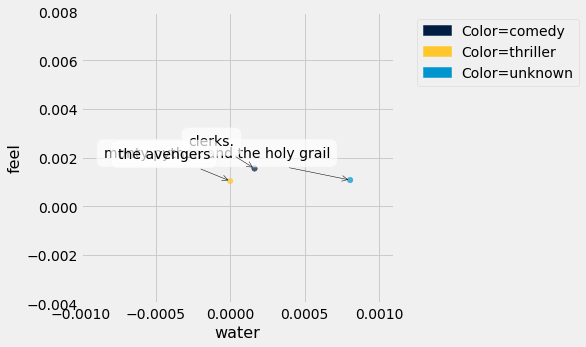

In [115]:
# Just run this cell.
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = row_for_title(test_movie)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['unknown'],
            'Title',   [test_movie]
        )
    for movie in training_movies:
        row = row_for_title(movie)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), movie])
    distances.scatter(x_feature, y_feature, group='Color', labels='Title', s=30)
    
training = ["clerks.", "the avengers"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel")
plots.axis([-0.001, 0.0011, -0.004, 0.008]);

#### Question 2.1.1

Compute the Euclidean distance (defined in the section above) between the two movies, *Monty Python and the Holy Grail* and *The Avengers*, using the `water` and `feel` features only.  Assign it the name `one_distance`.

**Note:** If you have a row, you can use `item` to get a value from a column by its name.  For example, if `r` is a row, then `r.item("Genre")` is the value in column `"Genre"` in row `r`.

*Hint*: Remember the function `row_for_title`, redefined for you below.

<!--
BEGIN QUESTION
name: q2_1_1
-->

In [116]:
title_index = movies.index_by('Title')
python = row_for_title("monty python and the holy grail") 
avengers = row_for_title("the avengers") 

one_distance = (((python.item("water")-avengers.item("water"))**2) + ((python.item("feel")-avengers.item("feel"))**2))**0.5
one_distance

0.0008050869157478908

In [117]:
ok.grade("q2_1_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Below, we've added a third training movie, *The Silence of the Lambs*. Before, the point closest to *Monty Python and the Holy Grail* was *Clerks.*, a comedy movie. However, now the closest point is *The Silence of the Lambs*, a thriller movie.

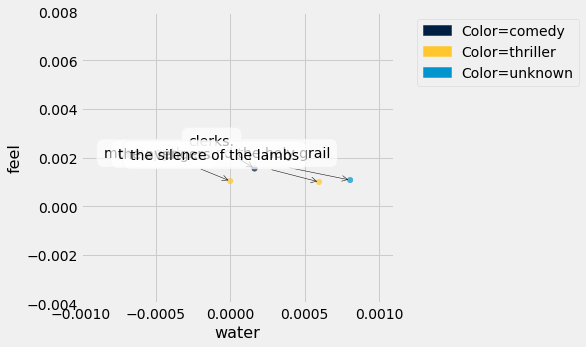

In [118]:
training = ["clerks.", "the avengers", "the silence of the lambs"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel") 
plots.axis([-0.001, 0.0011, -0.004, 0.008]);

#### Question 2.1.2
Complete the function `distance_two_features` that computes the Euclidean distance between any two movies, using two features. The last two lines call your function to show that *Monty Python and the Holy Grail* is closer to *The Silence of the Lambs* than it is to *Clerks*. 

<!--
BEGIN QUESTION
name: q2_1_2
-->

In [119]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two movies with titles title0 and title1
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = row_for_title(title0)
    row1 = row_for_title(title1)
    return (((row0.item(x_feature)-row1.item(x_feature))**2) + ((row0.item(y_feature)-row1.item(y_feature))**2))**0.5

for movie in make_array("clerks.", "the silence of the lambs"):
    movie_distance = distance_two_features(movie, "monty python and the holy grail", "water", "feel")
    print(movie, 'distance:\t', movie_distance)

clerks. distance:	 0.0007983810687227951
the silence of the lambs distance:	 0.00022256314855568916


In [120]:
ok.grade("q2_1_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2.1.3
Define the function `distance_from_python` so that it works as described in its documentation.

**Note:** Your solution should not use arithmetic operations directly. Instead, it should make use of existing functionality above!

<!--
BEGIN QUESTION
name: q2_1_3
-->

In [121]:
def distance_from_python(title):
    """The distance between the given movie and "monty python and the holy grail", 
    based on the features "water" and "feel".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    
    return distance_two_features(title, "monty python and the holy grail", "water", "feel")

In [122]:
ok.grade("q2_1_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2.1.4

Using the features `"water"` and `"feel"`, what are the names and genres of the 5 movies in the **training set** closest to *Monty Python and the Holy Grail*?  To answer this question, make a table named `close_movies` containing those 5 movies with columns `"Title"`, `"Genre"`, `"water"`, and `"feel"`, as well as a column called `"distance from python"` that contains the distance from *Monty Python and the Holy Grail*.  The table should be **sorted in ascending order by `distance from python`**.

<!--
BEGIN QUESTION
name: q2_1_4
-->

In [123]:

# The staff solution took multiple lines.
movie_water_feel = train_movies.select("Title", "Genre", "water", "feel")

movie_distances_arr = movie_water_feel.apply(distance_from_python, "Title")

close_movies = movie_water_feel.with_column("distance from python", movie_distances_arr).sort("distance from python", descending = False).take(np.arange(5))
close_movies

Title,Genre,water,feel,distance from python
alien,thriller,0.00070922,0.00124113,0.000193831
tomorrow never dies,thriller,0.000888889,0.000888889,0.00020189
the silence of the lambs,thriller,0.000595948,0.000993246,0.000222563
innerspace,comedy,0.000522193,0.00104439,0.00028324
some like it hot,comedy,0.000528541,0.000951374,0.00030082


In [124]:
ok.grade("q2_1_4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2.1.5
Next, we'll clasify *Monty Python and the Holy Grail* based on the genres of the closest movies. 

To do so, define the function `most_common` so that it works as described in its documentation below.

<!--
BEGIN QUESTION
name: q2_1_5
-->

In [125]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in that column of that table.
    In case of a tie, it returns any one of the most common values
    """
    grouped = table.group(label).sort("count", descending = True)
    return grouped.column(label).item(0)

# Calling most_common on your table of 5 nearest neighbors classifies
# "monty python and the holy grail" as a thriller movie, 3 votes to 2. 
most_common('Genre', close_movies)

'thriller'

In [126]:
ok.grade("q2_1_5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Congratulations are in order -- you've classified your first movie! However, we can see that the classifier doesn't work too well since it categorized *Monty Python and the Holy Grail* as a thriller movie (unless you count the thrilling holy hand grenade scene). Let's see if we can do better!

## Checkpoint (Due 11/20)
#### Congratulations, you have reached the first checkpoint! Run the submit cell below to generate the checkpoint submission.
To get full credit for this checkpoint, you must pass all the public autograder tests above this cell.

In [127]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'project3.ipynb'.
Submit... 100% complete
Submission successful for user: esong200@berkeley.edu
URL: https://okpy.org/cal/data8/fa20/project3/submissions/8Eg2Xo



# 3. Features

Now, we're going to extend our classifier to consider more than two features at a time.

Euclidean distance still makes sense with more than two features. For `n` different features, we compute the difference between corresponding feature values for two movies, square each of the `n`  differences, sum up the resulting numbers, and take the square root of the sum.

#### Question 3.0
Write a function called `distance` to compute the Euclidean distance between two **arrays** of **numerical** features (e.g. arrays of the proportions of times that different words appear). The function should be able to calculate the Euclidean distance between two arrays of arbitrary (but equal) length. 

Next, use the function you just defined to compute the distance between the first and second movie in the training set *using all of the features*.  (Remember that the first five columns of your tables are not features.)

**Note:** To convert rows to arrays, use `np.array`. For example, if `t` was a table, `np.array(t.row(0))` converts row 0 of `t` into an array.

**Note:** If you're working offline: Depending on the versions of your packages, you may need to convert rows to arrays using the following instead: `np.array(list(t.row(0))`

<!--
BEGIN QUESTION
name: q3_0
-->

In [128]:
def distance(features_array1, features_array2):
    """The Euclidean distance between two arrays of feature values."""
    return (sum((features_array1 - features_array2)**2))**0.5

first_movie = np.array(train_movies.drop(np.arange(5)).row(0))
second_movie = np.array(train_movies.drop(np.arange(5)).row(1))

distance_first_to_second = distance(first_movie, second_movie)
distance_first_to_second

0.03335446890881372

In [129]:
ok.grade("q3_0");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



## 3.1. Creating your own feature set

Unfortunately, using all of the features has some downsides.  One clear downside is *computational* -- computing Euclidean distances just takes a long time when we have lots of features.  You might have noticed that in the last question!

So we're going to select just 20.  We'd like to choose features that are very *discriminative*. That is, features which lead us to correctly classify as much of the test set as possible.  This process of choosing features that will make a classifier work well is sometimes called *feature selection*, or, more broadly, *feature engineering*.

#### Question 3.1.1
In this question, we will help you get started on selecting more effective features for distinguishing comedy from thriller movies. The plot below (generated for you) shows the average number of times each word occurs in a comedy movie on the horizontal axis and the average number of times it occurs in an thriller movie on the vertical axis.


*Note: The line graphed is the line of best fit, NOT a y=x*

![alt text](word_plot.png "Title")

The following questions ask you to interpret the plot above. For each question, select one of the following choices and assign its number to the provided name.
    1. The word is common in both comedy and thriller movies 
    2. The word is uncommon in comedy movies and common in thriller movies
    3. The word is common in comedy movies and uncommon in thriller movies
    4. The word is uncommon in both comedy and thriller movies
    5. It is not possible to say from the plot 
    
What properties does a word in the bottom left corner of the plot have? Your answer should be a single integer from 1 to 5, corresponding to the correct statement from the choices above.

<!--
BEGIN QUESTION
name: q3_1_1
-->

In [130]:
bottom_left = 4

In [131]:
ok.grade("q3_1_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3.1.2**

What properties does a word in the bottom right corner have?

<!--
BEGIN QUESTION
name: q3_1_2
-->

In [132]:
bottom_right = 3

In [133]:
ok.grade("q3_1_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3.1.3**

What properties does a word in the top right corner have?

<!--
BEGIN QUESTION
name: q3_1_3
-->

In [134]:
top_right = 1

In [135]:
ok.grade("q3_1_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3.1.4**

What properties does a word in the top left corner have?

<!--
BEGIN QUESTION
name: q3_1_4
-->

In [136]:
top_left = 2

In [137]:
ok.grade("q3_1_4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3.1.5**

If we see a movie with a lot of words that are common for comedy movies but uncommon for thriller movies, what would be a reasonable guess about the genre of the movie? Assign `movie_genre` to the number corresponding to your answer:
    1. It is a thriller movie.
    2. It is a comedy movie.
    
<!--
BEGIN QUESTION
name: q3_1_5
-->

In [138]:
movie_genre_guess = 2

In [139]:
ok.grade("q3_1_5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 3.1.6
Using the plot above, make an array of at least 10 common words that you think might let you distinguish between comedy and thriller movies. Make sure to choose words that are frequent enough that every movie contains at least one of them. Don't just choose the most frequent words, though--you can do much better.

You might want to come back to this question later to improve your list, once you've seen how to evaluate your classifier.  

<!--
BEGIN QUESTION
name: q3_1_6
-->

In [140]:
# Set my_features to an array of at least 10 features (strings that are column labels)
#movies.show(10)


my_features = make_array("love","dead", "question", "counterfeit", "price", "kill", "oh", "gun", "mean", "uh")

# Select the 10 features of interest from both the train and test sets
train_my_features = train_movies.select(my_features)
test_my_features = test_movies.select(my_features)

In [141]:
ok.grade("q3_1_6");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 5
    Failed: 0
[ooooooooook] 100.0% passed



This test makes sure that you have chosen words such that at least one appears in each movie. If you can't find words that satisfy this test just through intuition, try writing code to print out the titles of movies that do not contain any words from your list, then look at the words they do contain.

#### Question 3.1.7
In two sentences or less, describe how you selected your features.

<!--
BEGIN QUESTION
name: q3_1_7
manual: True
-->
<!-- EXPORT TO PDF -->

*Half of the words were more common in thriller movies than in comedy movies, and the other half were common in commedy movies than in thriller movies.*

Next, let's classify the first movie from our test set using these features.  You can examine the movie by running the cells below. Do you think it will be classified correctly?

In [142]:
print("Movie:")
test_movies.take(0).select('Title', 'Genre').show()
print("Features:")
test_my_features.take(0).show()

Movie:


Title,Genre
new nightmare,thriller


Features:


love,dead,question,counterfeit,price,kill,oh,gun,mean,uh
0.00109369,0.000364564,0,0,0,0.000729129,0.00145826,0,0.00291651,0


As before, we want to look for the movies in the training set that are most like our test movie.  We will calculate the Euclidean distances from the test movie (using `my_features`) to all movies in the training set.  You could do this with a `for` loop, but to make it computationally faster, we have provided a function, `fast_distances`, to do this for you.  Read its documentation to make sure you understand what it does.  (You don't need to understand the code in its body unless you want to.)

In [143]:
# Just run this cell to define fast_distances.

def fast_distances(test_row, train_table):
    """Return an array of the distances between test_row and each row in train_rows.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test movie (e.g., test_my_features.row(0)).
      train_table: A table of features (for example, the whole
        table train_my_features)."""
    assert train_table.num_columns < 50, "Make sure you're not using all the features of the movies table."
    counts_matrix = np.asmatrix(train_table.columns).transpose()
    diff = np.tile(np.array(list(test_row)), [counts_matrix.shape[0], 1]) - counts_matrix
    np.random.seed(0) # For tie breaking purposes
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    eps = np.random.uniform(size=distances.shape)*1e-10 #Noise for tie break
    distances = distances + eps
    return distances

#### Question 3.1.8
Use the `fast_distances` function provided above to compute the distance from the first movie in the test set to all the movies in the training set, **using your set of features**.  Make a new table called `genre_and_distances` with one row for each movie in the training set and two columns:
* The `"Genre"` of the training movie
* The `"Distance"` from the first movie in the test set 

Ensure that `genre_and_distances` is **sorted in ascending order by distance to the first test movie**.

<!--
BEGIN QUESTION
name: q3_1_8
-->

In [144]:
# The staff solution took multiple lines of code.
test_row = test_my_features.row(0)
distances = fast_distances(test_row, train_my_features)
genre_and_distances = train_movies.select("Genre").with_column("Distance", distances).sort("Distance", descending = False)
genre_and_distances

Genre,Distance
comedy,0.000759325
thriller,0.000808483
thriller,0.00100719
thriller,0.00101663
comedy,0.0011631
thriller,0.00116441
comedy,0.0012474
thriller,0.00129727
comedy,0.00132985
comedy,0.00133152


In [145]:
ok.grade("q3_1_8");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 4
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 3.1.9
Now compute the 7-nearest neighbors classification of the first movie in the test set.  That is, decide on its genre by finding the most common genre among its 7 nearest neighbors in the training set, according to the distances you've calculated.  Then check whether your classifier chose the right genre.  (Depending on the features you chose, your classifier might not get this movie right, and that's okay.)

<!--
BEGIN QUESTION
name: q3_1_9
-->

In [61]:
# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = most_common("Genre", genre_and_distances.take(np.arange(7)))

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first movie in the test set.
my_assigned_genre_was_correct = True

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

The assigned genre, thriller, was correct.


In [62]:
ok.grade("q3_1_9");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



## 3.2. A classifier function

Now we can write a single function that encapsulates the whole process of classification.

#### Question 3.2.1
Write a function called `classify`.  It should take the following four arguments:
* A row of features for a movie to classify (e.g., `test_my_features.row(0)`).
* A table with a column for each feature (e.g., `train_my_features`).
* An array of classes (e.g. the labels "comedy" or "thriller") that has as many items as the previous table has rows, and in the same order.
* `k`, the number of neighbors to use in classification.

It should return the class a `k`-nearest neighbor classifier picks for the given row of features (the string `'comedy'` or the string `'thriller'`).

<!--
BEGIN QUESTION
name: q3_2_1
-->

In [63]:
def classify(test_row, train_rows, train_labels, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_rows)
    genre_and_distances = Table().with_columns("Genre", train_labels, "Distance", distances).sort("Distance", descending = False)
    genre_and_distances_k = genre_and_distances.take(np.arange(k))
    
    return most_common("Genre", genre_and_distances_k)

In [64]:
ok.grade("q3_2_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 3.2.2

Assign `godzilla_genre` to the genre predicted by your classifier for the movie "godzilla" in the test set, using **15 neighbors** and using your 10 features.

<!--
BEGIN QUESTION
name: q3_2_2
-->

In [65]:
# The staff solution first defined a row called godzilla_features.
godzilla_features = test_movies.where("Title", are.containing("godzilla")).select(my_features).row(0)
train_labels =  train_movies.column("Genre")
godzilla_genre = classify(godzilla_features, train_my_features, train_labels, 15)
godzilla_genre

'comedy'

In [66]:
ok.grade("q3_2_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Finally, when we evaluate our classifier, it will be useful to have a classification function that is specialized to use a fixed training set and a fixed value of `k`.

#### Question 3.2.3
Create a classification function that takes as its argument a row containing your 10 features and classifies that row using the 15-nearest neighbors algorithm with `train_my_features` as its training set.

<!--
BEGIN QUESTION
name: q3_2_3
-->

In [67]:
def classify_feature_row(row):
    return classify(row, train_my_features , train_labels, 15)

# When you're done, this should produce 'Thriller' or 'Comedy'.
classify_feature_row(test_my_features.row(0))

'thriller'

In [68]:
ok.grade("q3_2_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 3.3. Evaluating your classifier

Now that it's easy to use the classifier, let's see how accurate it is on the whole test set.

**Question 3.3.1.** Use `classify_feature_row` and `apply` to classify every movie in the test set.  Assign these guesses as an array to `test_guesses`.  **Then**, compute the proportion of correct classifications. 

<!--
BEGIN QUESTION
name: q3_3_1
-->

In [81]:
test_guesses = test_my_features.apply(classify_feature_row)
test_labels =  test_movies.column("Genre")
proportion_correct = np.count_nonzero(test_guesses == test_labels)/len(test_guesses)
proportion_correct

0.7321428571428571

In [82]:
ok.grade("q3_3_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3.3.2.** An important part of evaluating your classifiers is figuring out where they make mistakes. Assign the name `test_movie_correctness` to a table with three columns, `'Title'`, `'Genre'`, and `'Was correct'`. The last column should contain `True` or `False` depending on whether or not the movie was classified correctly.

<!--
BEGIN QUESTION
name: q3_3_2
-->

In [83]:
# Feel free to use multiple lines of code
# but make sure to assign test_movie_correctness to the proper table!
was_correct = (test_guesses == test_labels)
test_movie_correctness = Table().with_columns("Title", test_movies.column("Title"), 
                                              "Genre", test_labels,
                                        "Was correct", was_correct)
test_movie_correctness.sort('Was correct', descending = True).show(50)

Title,Genre,Was correct
what women want,comedy,True
the war of the worlds,thriller,True
wonder boys,comedy,True
what lies beneath,thriller,True
o brother where art thou?,comedy,True
sphere,thriller,True
suspect zero,thriller,True
batman returns,thriller,True
star trek: the wrath of khan,thriller,True
monty python and the holy grail,comedy,True


In [72]:
ok.grade("q3_3_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3.3.3.** Do you see a pattern in the types of movies your classifier misclassifies? In two sentences or less, describe any patterns you see in the results or any other interesting findings from the table above. If you need some help, try looking up the movies that your classifier got wrong on Wikipedia.

<!--
BEGIN QUESTION
name: q3_3_3
manual: true
-->
<!-- EXPORT TO PDF -->

*Write your answer here, replacing this text.*

At this point, you've gone through one cycle of classifier design.  Let's summarize the steps:
1. From available data, select test and training sets.
2. Choose an algorithm you're going to use for classification.
3. Identify some features.
4. Define a classifier function using your features and the training set.
5. Evaluate its performance (the proportion of correct classifications) on the test set.

## 4. Explorations
Now that you know how to evaluate a classifier, it's time to build a better one.

#### Question 4.1
Develop a classifier with better test-set accuracy than `classify_feature_row`.  Your new function should have the same arguments as `classify_feature_row` and return a classification.  Name it `another_classifier`. Then, check your accuracy using code from earlier.

You can use more or different features, or you can try different values of `k`. (Of course, you still have to use `train_movies` as your training set!) 

**Make sure you don't reassign any previously used variables here**, such as `proportion_correct` from the previous question.

In [75]:
# To start you off, here's a list of possibly-useful features
# Feel free to add or change this array to improve your classifier

new_features = make_array("laugh", "marri", "dead", "heart", "cop", "uh"
                          , "run", "counterfeit", "kill", "oh", "gun"
                          , "mean", "well")

train_new = train_movies.select(new_features)
test_new = test_movies.select(new_features)


def another_classifier(row):
    return classify(row, train_new , train_labels, 10)

new_test_guesses = test_new.apply(another_classifier)
new_test_labels =  test_movies.column("Genre")
new_proportion_correct = np.count_nonzero(new_test_guesses == new_test_labels)/len(new_test_guesses)
new_proportion_correct

0.75

**Question 4.2** 

Do you see a pattern in the mistakes your new classifier makes? What about in the improvement from your first classifier to the second one? Describe in two sentences or less.

**Hint:** You may not be able to see a pattern.

<!--
BEGIN QUESTION
name: q4_2
manual: true
-->
<!-- EXPORT TO PDF -->

*The classifier makes more mistakes with movies that are either a mix bf both categories or movies that are really one category but could have themes or dialogue that makes it seem like it's the other.*

**Question 4.3**

Briefly describe what you tried to improve your classifier. 

<!--
BEGIN QUESTION
name: q4_3
manual: true
-->
<!-- EXPORT TO PDF -->

*I simply tried to add more features, but also adding feature that were common in one but not common in the other.*

Congratulations: you're done with the required portion of the project! Time to submit.

In [ ]:
_ = ok.submit()

<IPython.core.display.Javascript object>

## 5. Other Classification Methods (OPTIONAL)

**Note**: Everything below is **OPTIONAL**. Please only work on this part after you have finished and submitted the project. If you create new cells below, do NOT reassign variables defined in previous parts of the project.

Now that you've finished your k-NN classifier, you might be wondering what else you could do to improve your accuracy on the test set. Classification is one of many machine learning tasks, and there are plenty of other classification algorithms! If you feel so inclined, we encourage you to try any methods you feel might help improve your classifier. 

We've compiled a list of blog posts with some more information about classification and machine learning. Create as many cells as you'd like below--you can use them to import new modules or implement new algorithms. 

Blog posts: 

* [Classification algorithms/methods](https://medium.com/@sifium/machine-learning-types-of-classification-9497bd4f2e14)
* [Train/test split and cross-validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)
* [More information about k-nearest neighbors](https://medium.com/@adi.bronshtein/a-quick-introduction-to-k-nearest-neighbors-algorithm-62214cea29c7)
* [Overfitting](https://elitedatascience.com/overfitting-in-machine-learning)

In future data science classes, such as Data Science 100, you'll learn about some about some of the algorithms in the blog posts above, including logistic regression. You'll also learn more about overfitting, cross-validation, and approaches to different kinds of machine learning problems.

There's a lot to think about, so we encourage you to find more information on your own!

Modules to think about using:

* [Scikit-learn tutorial](http://scikit-learn.org/stable/tutorial/basic/tutorial.html)
* [TensorFlow information](https://www.tensorflow.org/tutorials/)

...and many more!

In [107]:
...

In [146]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q') and len(q) <= 10]
print("Finished running all tests.")

Running all tests...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running t